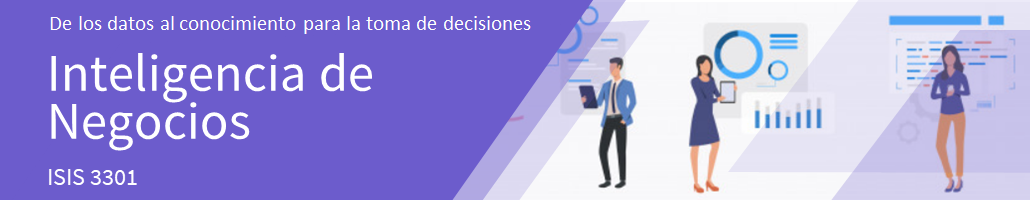

# Machine Learning supervisado, clasificación

El objetivo de este notebook es mostrar como resolver un problema de clasificación utilizando la librería scikit-learn. A partir del caso SpotiAlpes trabajado anteriormente, se realiza la preparación de datos requerida para posteriormente entrenar algunos modelos de clasificación que permitan determinar la popularidad de una canción dados sus demás atributos. Adicionalmente, se abordan las métricas típicas para evaluar modelos de clasificación en terminos de su capacidad de generalización así como estrategias para realizar ajustes sobre los hiperparámetros de los algoritmos con el objetivo de selecccionar el mejor modelo.

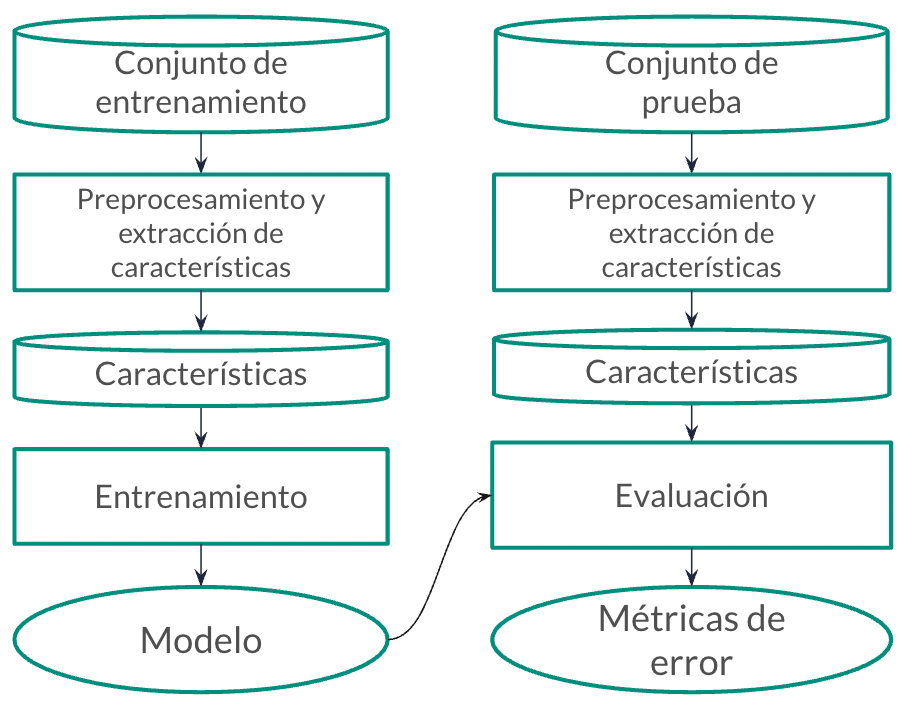

In [1]:
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar

## 1. Carga de los datos

In [3]:
df_tracks = pd.read_csv('./data/PrepTracks.csv', index_col = 0)

In [4]:
df_tracks.shape

(100000, 22)

In [5]:
df_tracks.head()

id  \
280776  1P2kvbKXc8lomaeMoS1GPd   
413741  3cfsrtjbPNbgcmgSRsJgbN   
347767  2yuyaYAELoMG4ApV5wJsWR   
25439   4dyemWgZn8CG9qneSpcQA3   
65901   4J2nhinyaIxkoGh9vw5UbI   

                                                     name  popularity  \
280776                              Tipota Den Pai Hameno         6.0   
413741                                       Tu Enamorado        34.0   
347767                           Curve (feat. The Weeknd)        62.0   
25439                                     Tennessee Waltz        12.0   
65901   Have I Told You Lately - Live Unplugged; 2008 ...        47.0   

        duration_ms  explicit                                     artists  \
280776       246467       0.0                           ["Haris Alexiou"]   
413741       157800       0.0                    ["José Alfredo Jimenez"]   
347767       161990       1.0                ["Gucci Mane", "The Weeknd"]   
25439        179293       0.0  ["Pee Wee King & His Golden West Cowboys"]   
65901        243947       0.0                             ["Rod Stewart"]   

                                               id_artists release_date  \
280776                         ['4cgCxnsmy9kDcl3oA2BYRY']   1979-05-02   
413741                         ['2T06whb4s6UiufL1j5Qtz9']   1999-12-31   
347767  ['13y7CgLHjMVRMDqxdx0Xdo', '1Xyo4u8uXC1ZmMpatF...   2017-10-13   
25439                          ['3iywlJzFl8iYgp3112qt31']   1952-06-13   
65901                          ['2y8Jo9CKhJvtfeKOsYzRdT']   1993-05-01   

        danceability  energy  loudness mode  decibel_range  speechiness  \
280776         0.399   0.397   -10.659    m            NaN       0.0260   
413741         0.454   0.470   -10.255    M            NaN       0.0413   
347767         0.760   0.476    -8.103    M            NaN       0.2410   
25439          0.541   0.153   -15.171    M            NaN       0.0352   
65901          0.476   0.331   -14.461    M            NaN       0.0427   

        acousticness  instrumentalness  liveness  valence    tempo  \
280776         0.638          0.000000    0.1170    0.475   93.146   
413741         0.793          0.000000    0.0750    0.857  148.411   
347767         0.294          0.000000    0.1000    0.354  147.010   
25439          0.912          0.000290    0.0979    0.675  114.834   
65901          0.792          0.000004    0.7160    0.315   66.825   

        time_signature                            first_artist second_artist  
280776             4.0                           Haris Alexiou           NaN  
413741             3.0                    José Alfredo Jimenez           NaN  
347767             4.0                              Gucci Mane    The Weeknd  
25439              3.0  Pee Wee King & His Golden West Cowboys           NaN  
65901              4.0                             Rod Stewart           NaN

## 2. Entendimiento de los datos

In [6]:
df_tracks.dtypes

id                   object
name                 object
popularity          float64
duration_ms           int64
explicit            float64
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
loudness            float64
mode                 object
decibel_range       float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
first_artist         object
second_artist        object
dtype: object

In [7]:
df_tracks.describe()

popularity   duration_ms      explicit  danceability        energy  \
count  99910.000000  1.000000e+05  99908.000000  99909.000000  99907.000000   
mean      27.478090  2.324164e+05      0.045732      0.562213      0.542298   
std       18.480398  1.249293e+05      0.208904      0.166364      0.252587   
min        0.000000  3.344000e+03      0.000000      0.000000      0.000000   
25%       12.000000  1.775600e+05      0.000000      0.451000      0.343000   
50%       27.000000  2.160400e+05      0.000000      0.574000      0.550000   
75%       41.000000  2.646000e+05      0.000000      0.685000      0.749000   
max       90.000000  4.685927e+06      1.000000      0.987000      1.000000   

           loudness  decibel_range   speechiness  acousticness  \
count  99893.000000     155.000000  99901.000000  99911.000000   
mean     -10.150200      47.709677      0.092128      0.449463   
std        5.065804      29.896785      0.151199      0.349990   
min      -60.000000       0.000000      0.000000      0.000000   
25%      -12.805000      21.000000      0.033800      0.094900   
50%       -9.181000      49.000000      0.043700      0.420000   
75%       -6.457000      73.500000      0.072900      0.787000   
max        2.572000      99.000000      0.971000      0.996000   

       instrumentalness      liveness       valence         tempo  \
count      99900.000000  99907.000000  99900.000000  99898.000000   
mean           0.114129      0.209558      0.551855    118.656852   
std            0.266812      0.181309      0.258919     29.701265   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.097600      0.343000     95.880250   
50%            0.000029      0.136000      0.563000    117.693000   
75%            0.011100      0.269000      0.772000    136.513750   
max            1.000000      1.000000      1.000000    243.759000   

       time_signature  
count    99909.000000  
mean         3.880371  
std          0.456019  
min          0.000000  
25%          4.000000  
50%          4.000000  
75%          4.000000  
max          5.000000

In [8]:
# Por defecto, la función describe analiza solo las columnas numéricas
# Pasando este parámetro exclude, realizará el análisis sobre las columnas no numéricas 
df_tracks.describe(exclude = [np.int64, np.float64])

id   name              artists  \
count                    99893  99888               100000   
unique                   99890  91341                39005   
top     0CQPWcVvEP0YqJudrQp3Pt  Angel  ["Lata Mangeshkar"]   
freq                         2     20                  242   

                        id_artists release_date   mode     first_artist  \
count                       100000        99911  99894            99988   
unique                       39182        14200      5            30447   
top     ['61JrslREXq98hurYL2hYoc']   1997-01-01      M  Lata Mangeshkar   
freq                           242          506  65882              429   

       second_artist  
count          18369  
unique          9131  
top      Tomas Bolme  
freq             163

Un entendimiento profundo del contexto en el que se está trabajando (negocio) y de los datos permite definir mejor el alcance y las limitaciones del proyecto de analítica, iterar más rápido sobre las diferentes etapas establecidas en la metodología y maximizar el impacto del proyecto.

## 3. Limpieza y preparación de los datos

Los procesos de limpieza y preparación de datos están relacionados con el problema a resolver, las características de los datos y el algoritmo a utilizar. Tanto los pasos previos de entendimiento como los siguientes de limpieza y preparación NO deben ser tomados como una receta que siempre debe ser aplicada.

In [9]:
(df_tracks.isnull().sum() / df_tracks.shape[0]).sort_values(ascending = False)

decibel_range       0.99845
second_artist       0.81631
name                0.00112
loudness            0.00107
id                  0.00107
mode                0.00106
tempo               0.00102
instrumentalness    0.00100
valence             0.00100
speechiness         0.00099
energy              0.00093
liveness            0.00093
explicit            0.00092
danceability        0.00091
time_signature      0.00091
popularity          0.00090
acousticness        0.00089
release_date        0.00089
first_artist        0.00012
duration_ms         0.00000
id_artists          0.00000
artists             0.00000
dtype: float64

In [10]:
# Se eliminan algunas columnas que no se usarán, entre otras cosas, por su alto porcentaje de valores nulos
df_tracks.drop(['decibel_range', 'second_artist'], axis = 1, inplace = True)

Al realizar procesos de remoción de registros por duplicidad o nulidad, siempre es útil tener control del total de registros que se estan perdiendo.

In [11]:
df_tracks.shape

(100000, 20)

In [12]:
df_tracks.drop_duplicates(subset = 'id', keep = 'first', inplace = True)

In [13]:
df_tracks.shape

(99891, 20)

Una estrategia básica de imputar valores faltantes es utilizar el promedio, mediana o moda, dependiendo del tipo de dato

In [14]:
df_tracks['loudness'].fillna(df_tracks['loudness'].mean(), inplace = True)
df_tracks['mode'].fillna(df_tracks['mode'].mode(), inplace = True)

Remover registros con valores faltantes debe ser la última opción a considerar

In [15]:
df_tracks.dropna(inplace = True)

In [16]:
df_tracks.shape

(98547, 20)

In [17]:
(df_tracks.isnull().sum() / df_tracks.shape[0]).sort_values(ascending = False)

id                  0.0
name                0.0
time_signature      0.0
tempo               0.0
valence             0.0
liveness            0.0
instrumentalness    0.0
acousticness        0.0
speechiness         0.0
mode                0.0
loudness            0.0
energy              0.0
danceability        0.0
release_date        0.0
id_artists          0.0
artists             0.0
explicit            0.0
duration_ms         0.0
popularity          0.0
first_artist        0.0
dtype: float64

### Construcción de la variable objetivo

Los tomadores de decisiones desean tener un modelo que les permita establecer si una canción será popular o no dados los atributos que se tienen a disposición. No de cuenta con un indicador "binario" de popularidad pero si con su correspondiente numérico.

Dicho esto, la variable objetivo deberá ser obtenida de la columna numérica popularidad utilizando un umbral que permita determinar cuándo una canción es popular. Si el valor de popularidad para una canción dada es mayor al umbral establecido, dicha canción es marcada como "popular" (popularity_label = 1), de lo contrario es marcada como "no popular" (popularity_label = 0).

Text(0.5, 1.0, 'Distribución de la popularidad de las canciones')

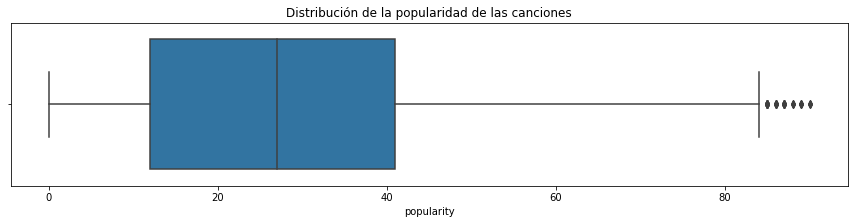

In [18]:
fig = plt.figure(figsize = (15, 3))
ax = sns.boxplot(x = 'popularity', data = df_tracks)
plt.title('Distribución de la popularidad de las canciones')

In [19]:
df_tracks['popularity'].describe(percentiles = [.25, .5, .6, .75])

count    98547.000000
mean        27.487503
std         18.486265
min          0.000000
25%         12.000000
50%         27.000000
60%         32.000000
75%         41.000000
max         90.000000
Name: popularity, dtype: float64

A partir del conocimiento del negocio, se define que el umbral de decisión debe ser el percentil 60, es decir 32 puntos de popularidad.

In [20]:
# Se aplica una función que analiza la columna de popularidad y crea una nueva (popularity_label) representando la variable objetivo
df_tracks['popularity_label'] = df_tracks['popularity'].apply(lambda x: 1 if x > 32 else 0)

In [21]:
df_tracks['popularity_label'].value_counts(normalize = True)

0    0.602677
1    0.397323
Name: popularity_label, dtype: float64

Text(0.5, 1.0, 'Distribución de la variable objetivo')

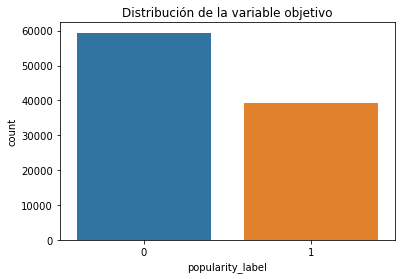

In [22]:
# Se verifica la distribución de la variable objetivo
# ¿Tiene sentido esta distribución?
ax = sns.countplot(x = 'popularity_label', data = df_tracks)
plt.title('Distribución de la variable objetivo')

In [23]:
df_tracks.head()

id  \
280776  1P2kvbKXc8lomaeMoS1GPd   
413741  3cfsrtjbPNbgcmgSRsJgbN   
347767  2yuyaYAELoMG4ApV5wJsWR   
25439   4dyemWgZn8CG9qneSpcQA3   
65901   4J2nhinyaIxkoGh9vw5UbI   

                                                     name  popularity  \
280776                              Tipota Den Pai Hameno         6.0   
413741                                       Tu Enamorado        34.0   
347767                           Curve (feat. The Weeknd)        62.0   
25439                                     Tennessee Waltz        12.0   
65901   Have I Told You Lately - Live Unplugged; 2008 ...        47.0   

        duration_ms  explicit                                     artists  \
280776       246467       0.0                           ["Haris Alexiou"]   
413741       157800       0.0                    ["José Alfredo Jimenez"]   
347767       161990       1.0                ["Gucci Mane", "The Weeknd"]   
25439        179293       0.0  ["Pee Wee King & His Golden West Cowboys"]   
65901        243947       0.0                             ["Rod Stewart"]   

                                               id_artists release_date  \
280776                         ['4cgCxnsmy9kDcl3oA2BYRY']   1979-05-02   
413741                         ['2T06whb4s6UiufL1j5Qtz9']   1999-12-31   
347767  ['13y7CgLHjMVRMDqxdx0Xdo', '1Xyo4u8uXC1ZmMpatF...   2017-10-13   
25439                          ['3iywlJzFl8iYgp3112qt31']   1952-06-13   
65901                          ['2y8Jo9CKhJvtfeKOsYzRdT']   1993-05-01   

        danceability  energy  loudness mode  speechiness  acousticness  \
280776         0.399   0.397   -10.659    m       0.0260         0.638   
413741         0.454   0.470   -10.255    M       0.0413         0.793   
347767         0.760   0.476    -8.103    M       0.2410         0.294   
25439          0.541   0.153   -15.171    M       0.0352         0.912   
65901          0.476   0.331   -14.461    M       0.0427         0.792   

        instrumentalness  liveness  valence    tempo  time_signature  \
280776          0.000000    0.1170    0.475   93.146             4.0   
413741          0.000000    0.0750    0.857  148.411             3.0   
347767          0.000000    0.1000    0.354  147.010             4.0   
25439           0.000290    0.0979    0.675  114.834             3.0   
65901           0.000004    0.7160    0.315   66.825             4.0   

                                  first_artist  popularity_label  
280776                           Haris Alexiou                 0  
413741                    José Alfredo Jimenez                 1  
347767                              Gucci Mane                 1  
25439   Pee Wee King & His Golden West Cowboys                 0  
65901                              Rod Stewart                 1

### Selección de atributos / features para la clasificación

No todos las columnas disponibles en el conjunto de datos son aptas para ser usadas como features para el entrenamiento del modelo.  

En primera instancia, se trabaja solo con las columnas numéricas que existen en el conjunto de datos. Algunos algoritmos solo admiten este tipo de features.

In [24]:
features = ['duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

### Particionamiento del conjunto de datos en entrenamiento y prueba

Se utiliza la estrategia hold-out.

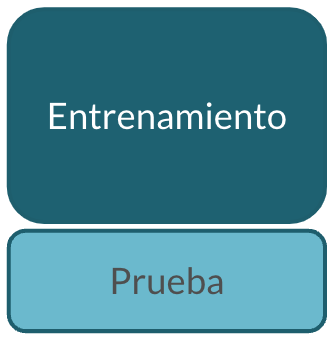

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(df_tracks[features], df_tracks['popularity_label'], test_size = 0.2, random_state = 0)

In [26]:
print('Tamaño del conjunto original:', df_tracks.shape[0])
print('Tamaño del conjunto de entrenamiento:', X_train.shape[0])
print('Tamaño del conjunto de prueba:', X_test.shape[0])

Tamaño del conjunto original: 98547
Tamaño del conjunto de entrenamiento: 78837
Tamaño del conjunto de prueba: 19710


In [27]:
Y_train.value_counts(normalize = True)

0    0.602382
1    0.397618
Name: popularity_label, dtype: float64

In [28]:
Y_test.value_counts(normalize = True)

0    0.603856
1    0.396144
Name: popularity_label, dtype: float64

## 4. "Entrenamiento" de un primer "modelo" usando K-Nearest Neighbors (KNN)

¿Tiene sentido hablar de entrenamiento y modelo al utilizar el algoritmo KNN?

In [29]:
knn_model = KNeighborsClassifier(n_neighbors = 3) # 5 neighbors is the default value

¿Qué impacto tiene el hiperparámetro *n_neighbors*?

In [30]:
# Entrenamiento del "modelo"
knn_model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [31]:
# Generación de predicciones para entrenamiento y test para el cálculo de errores
preds_train = knn_model.predict(X_train)
preds_test = knn_model.predict(X_test)

In [32]:
# Se evalua la accuracy (1 - error) del "modelo" en ambos conjuntos en términos porcentuales: porcetaje de instancias bien etiquetadas:
print('Accuracy (train):', accuracy_score(Y_train, preds_train))
print('Accuracy (test):', accuracy_score(Y_test, preds_test))

Accuracy (train): 0.7770843639407892
Accuracy (test): 0.5636732623033993


¿Cómo saber si se equivocó más prediciendo la clase positiva (popular) o negativa (no popular)?  

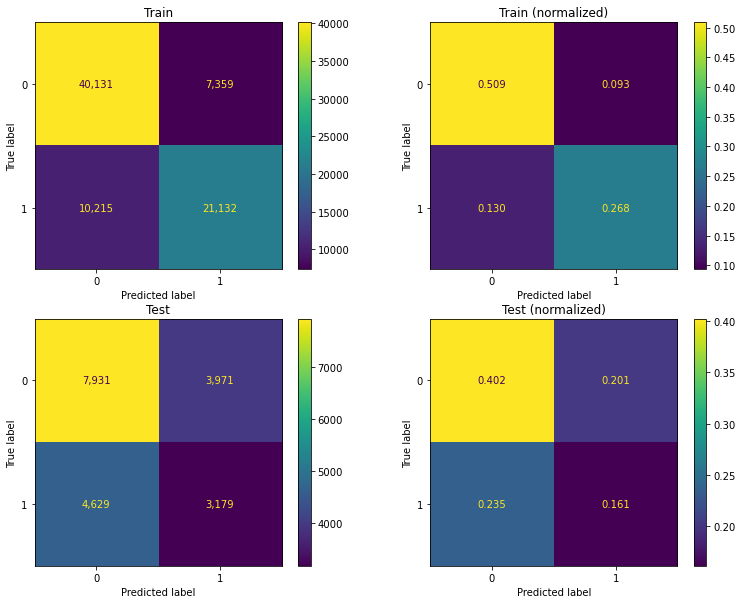

In [33]:
# Se empieza calculando la matriz de confusión

cm_train = confusion_matrix(Y_train, preds_train, labels = knn_model.classes_)
cm_train_norm = confusion_matrix(Y_train, preds_train, labels = knn_model.classes_, normalize = 'all')
cm_test = confusion_matrix(Y_test, preds_test, labels = knn_model.classes_)
cm_test_norm = confusion_matrix(Y_test, preds_test, labels = knn_model.classes_, normalize = 'all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = knn_model.classes_).plot(ax = ax1, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = knn_model.classes_).plot(ax = ax2, values_format = '.3f')
ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = knn_model.classes_).plot(ax = ax3, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_test_norm, display_labels = knn_model.classes_).plot(ax = ax4, values_format = '.3f')

ax1.set_title('Train')
ax2.set_title('Train (normalized)')
ax3.set_title('Test')
ax4.set_title('Test (normalized)')
plt.show()

In [34]:
# Se calculan las diferentes métricas de error para una comparacion más directa:
pd.DataFrame([
    {
        'Train': accuracy_score(Y_train, preds_train),
        'Test': accuracy_score(Y_test, preds_test)
    },
    {
        'Train': precision_score(Y_train, preds_train),
        'Test': precision_score(Y_test, preds_test)
    },
    {
        'Train': recall_score(Y_train, preds_train),
        'Test': recall_score(Y_test, preds_test)
    },
    {
        'Train': f1_score(Y_train, preds_train),
        'Test': f1_score(Y_test, preds_test)
    }
], index = ['Accuracy', 'Precision', 'Recall', 'F1'])

Train      Test
Accuracy   0.777084  0.563673
Precision  0.741708  0.444615
Recall     0.674131  0.407147
F1         0.706307  0.425057

## 5. Ingeniería de características

Construir una matriz de características usando solo datos numéricos y sin valores faltantes no es el único requisito que tienen algunos algoritmos para garantizar un *buen funcionamiento*.  
  
Algunos algoritmos internamente procesan distancias euclidianas, medias, entre otras medidas, que pueden verse afectadas por la escala de los datos y la presencia de valores atípicos.  
  
Una práctica común es estandarizar los datos, asegurandose de que todos se encuentren en la misma escala.  
  
Hay muchas varias formas de realizar este proceso. Una de ellas es removiendo la media y escalando a varianza unitaria:  
z = (x - u) / s

In [35]:
X_train[features].head()

duration_ms  explicit  danceability  energy  loudness  speechiness  \
402251       354662       0.0         0.667   0.948    -4.561       0.0469   
72671        259147       0.0         0.632   0.771    -5.063       0.0353   
187758       240027       0.0         0.527   0.810    -9.643       0.1400   
269604       544987       0.0         0.455   0.754    -5.716       0.0303   
542463       315813       0.0         0.534   0.936    -4.429       0.0883   

        acousticness  instrumentalness  liveness  valence    tempo  \
402251       0.00504          0.000000    0.2660    0.322  115.999   
72671        0.50300          0.000000    0.1410    0.723  113.230   
187758       0.00124          0.000699    0.0497    0.704  156.934   
269604       0.00587          0.000000    0.1420    0.568  139.358   
542463       0.01630          0.000000    0.1520    0.353  127.930   

        time_signature  
402251             4.0  
72671              4.0  
187758             4.0  
269604             4.0  
542463             4.0

<AxesSubplot:>

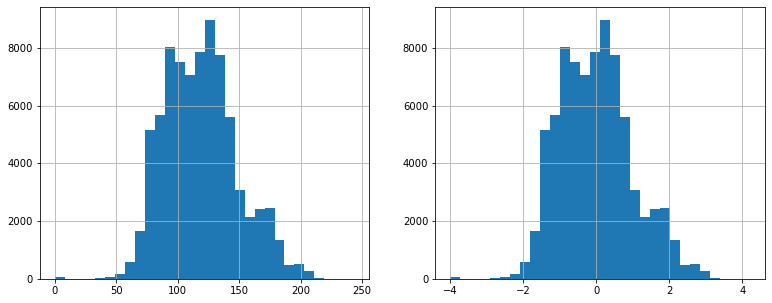

In [36]:
# Para ejemplificación, se dibujan los histogramas de la variable tempo original y la estandarizada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))
X_train['tempo'].hist(bins = 30, ax = ax1)
((X_train['tempo'] - X_train['tempo'].mean()) / X_train['tempo'].std()).hist(bins = 30, ax = ax2)

In [37]:
# En este caso, fit se encarga de calcular la media y la desviación estándar de cada feature, usadas posteriormente para transformar los datos
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

## 6. Entrenamiento de un segundo "modelo" basado en KNN

En este caso se hace el proceso previo de estandarización de los datos, tanto para el *fit* como para el *predict*.

In [38]:
knn_model.fit(scaler.transform(X_train), Y_train)

KNeighborsClassifier(n_neighbors=3)

In [39]:
# Note que antes de llamar la función predict, los datos son pasados por la función transform
preds_train = knn_model.predict(scaler.transform(X_train))
preds_test = knn_model.predict(scaler.transform(X_test))

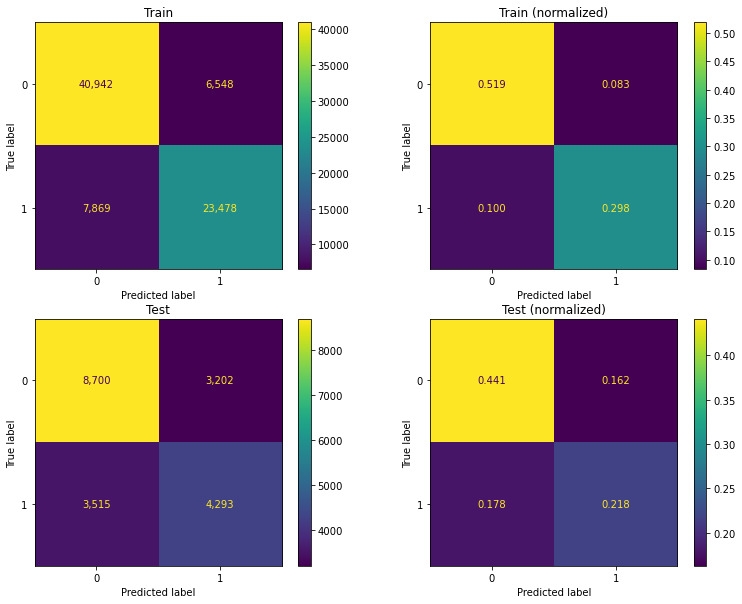

In [40]:
cm_train = confusion_matrix(Y_train, preds_train, labels = knn_model.classes_)
cm_train_norm = confusion_matrix(Y_train, preds_train, labels = knn_model.classes_, normalize = 'all')
cm_test = confusion_matrix(Y_test, preds_test, labels = knn_model.classes_)
cm_test_norm = confusion_matrix(Y_test, preds_test, labels = knn_model.classes_, normalize = 'all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = knn_model.classes_).plot(ax = ax1, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = knn_model.classes_).plot(ax = ax2, values_format = '.3f')
ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = knn_model.classes_).plot(ax = ax3, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_test_norm, display_labels = knn_model.classes_).plot(ax = ax4, values_format = '.3f')

ax1.set_title('Train')
ax2.set_title('Train (normalized)')
ax3.set_title('Test')
ax4.set_title('Test (normalized)')
plt.show()

In [41]:
pd.DataFrame([
    {
        'Train': accuracy_score(Y_train, preds_train),
        'Test': accuracy_score(Y_test, preds_test)
    },
    {
        'Train': precision_score(Y_train, preds_train),
        'Test': precision_score(Y_test, preds_test)
    },
    {
        'Train': recall_score(Y_train, preds_train),
        'Test': recall_score(Y_test, preds_test)
    },
    {
        'Train': f1_score(Y_train, preds_train),
        'Test': f1_score(Y_test, preds_test)
    }
], index = ['Accuracy', 'Precision', 'Recall', 'F1'])

Train      Test
Accuracy   0.817129  0.659209
Precision  0.781922  0.572782
Recall     0.748971  0.549821
F1         0.765092  0.561066

## 7. Cambiando el algoritmo por un Árbol de Decisión

Este algoritmo **NO** es sensible a features en diferentes escalas razón por la cual no se requiere realizar el proceso de estandarización.    
  
Para propósitos de exploración, primero se construirá un modelo simple controlando la profundidad del árbol.

In [42]:
# La complejidad del árbol es controlada limitando la máxima profundidad que tendrá tras su entrenamiento
tree_model = DecisionTreeClassifier(max_depth = 2, random_state = 1)

In [43]:
tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

Los modelos de árboles de decisión son interesantes en la medida en que pueden ser interpretados como reglas de decisión. Es posible dibujar el árbol de decisión con el fin de entender dichas reglas.

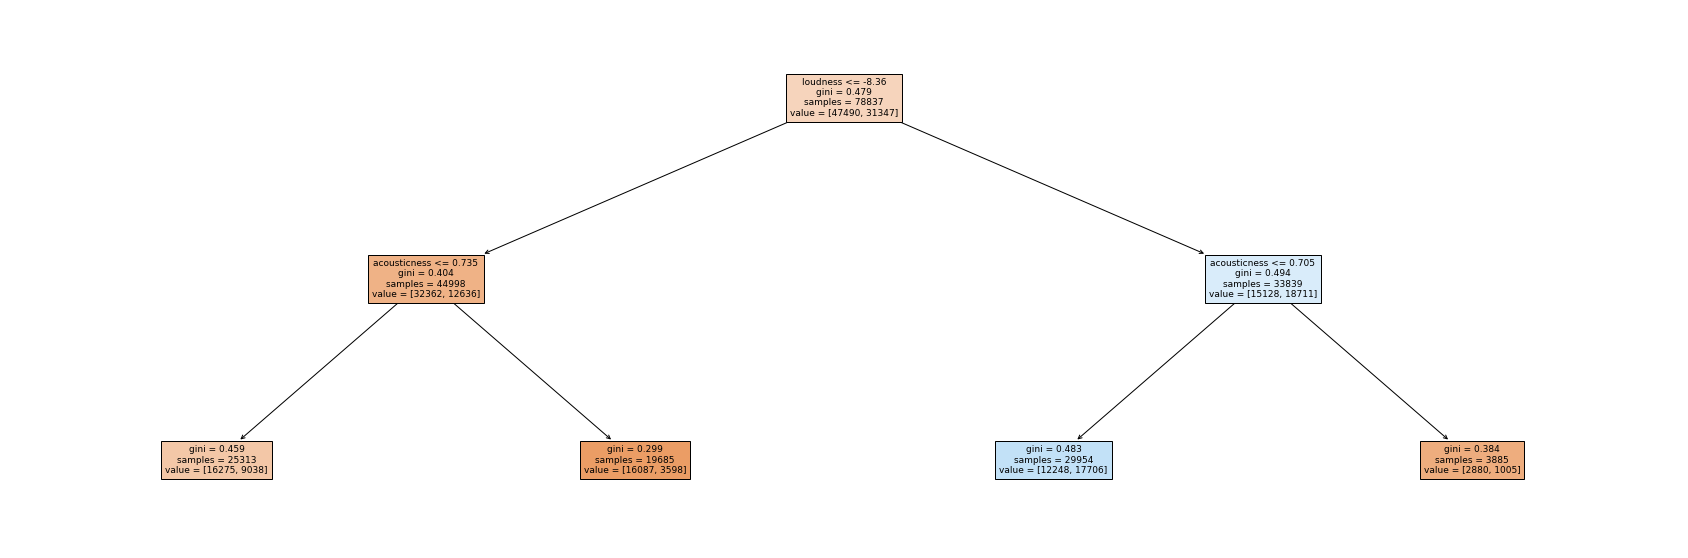

In [44]:
fig = plt.figure(figsize = (30, 10))
_ = tree.plot_tree(tree_model, max_depth = 3, feature_names = features, filled = True, fontsize = 9)

In [45]:
preds_train = tree_model.predict(X_train)
preds_test = tree_model.predict(X_test)

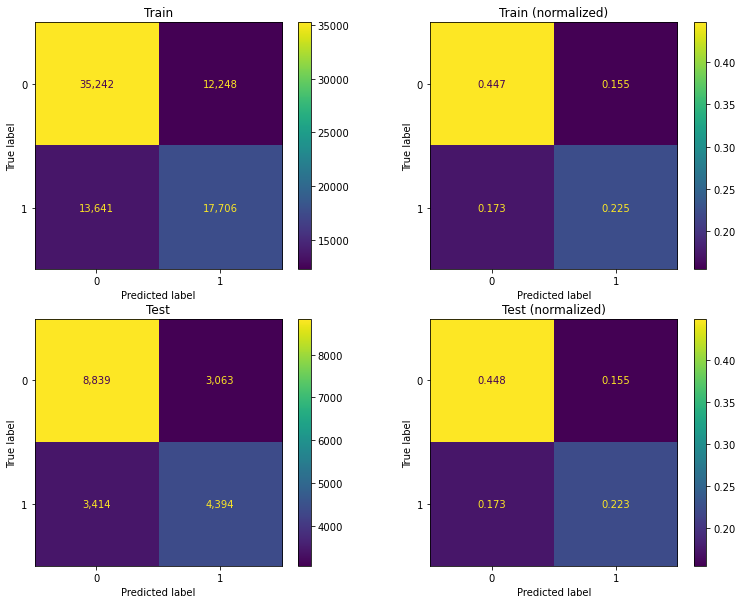

In [46]:
cm_train = confusion_matrix(Y_train, preds_train, labels = tree_model.classes_)
cm_train_norm = confusion_matrix(Y_train, preds_train, labels = tree_model.classes_, normalize = 'all')
cm_test = confusion_matrix(Y_test, preds_test, labels = tree_model.classes_)
cm_test_norm = confusion_matrix(Y_test, preds_test, labels = tree_model.classes_, normalize = 'all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = tree_model.classes_).plot(ax = ax1, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = tree_model.classes_).plot(ax = ax2, values_format = '.3f')
ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = tree_model.classes_).plot(ax = ax3, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_test_norm, display_labels = tree_model.classes_).plot(ax = ax4, values_format = '.3f')

ax1.set_title('Train')
ax2.set_title('Train (normalized)')
ax3.set_title('Test')
ax4.set_title('Test (normalized)')
plt.show()

In [47]:
pd.DataFrame([
    {
        'Train': accuracy_score(Y_train, preds_train),
        'Test': accuracy_score(Y_test, preds_test)
    },
    {
        'Train': precision_score(Y_train, preds_train),
        'Test': precision_score(Y_test, preds_test)
    },
    {
        'Train': recall_score(Y_train, preds_train),
        'Test': recall_score(Y_test, preds_test)
    },
    {
        'Train': f1_score(Y_train, preds_train),
        'Test': f1_score(Y_test, preds_test)
    }
], index = ['Accuracy', 'Precision', 'Recall', 'F1'])

Train      Test
Accuracy   0.671614  0.671385
Precision  0.591106  0.589245
Recall     0.564839  0.562756
F1         0.577674  0.575696

Note que el error de prueba se logra mejorar un poco pero el error de entrenamiento parece aumentar. Este escenario en general es un poco más deseado en términos de la capacidad de generalización del modelo.  
  
En términos de la teoría del Machine Learning, el problema de tener bajo error de entrenamiento pero un alto error de prueba se conoce como **overfitting** vs. otro tipo de problema el cuál consiste en tener errores altos tanto en entrenamiento como en prueba conocido **underfitting**. En términos prácticos, se puede decir que los "modelos" previos construidos utilizando KNN presentan sobreajuste (**overfitting**).

## 8. Entrenando un Árbol de Decisión de mayor complejidad

Al no controlar la complejidad del árbol, éste tendrá tanta profundidad que le permitirá clasificar la mayor cantidad de instancias de entrenamiento posibles.

In [48]:
tree_model = DecisionTreeClassifier(random_state = 1)

In [49]:
tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=1)

In [50]:
# Se comprueba la profundidad del árbol resultante
tree_model.get_depth()

44

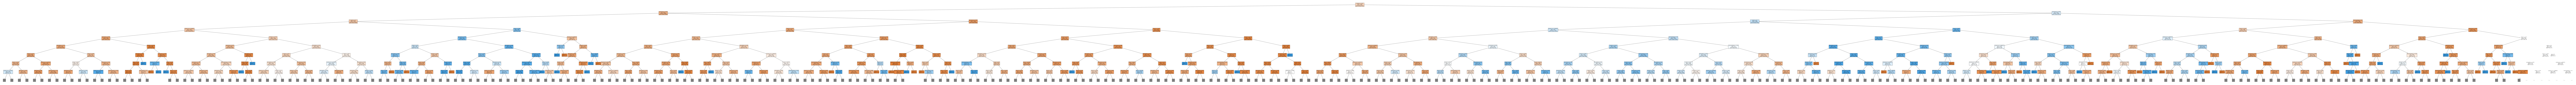

In [51]:
fig = plt.figure(figsize = (600, 20))
_ = tree.plot_tree(tree_model, max_depth = 8, feature_names = features, filled = True, fontsize = 9)
fig.savefig('decistion_tree.png') # También es posible guardar esta figura como una imagen

In [52]:
preds_train = tree_model.predict(X_train)
preds_test = tree_model.predict(X_test)

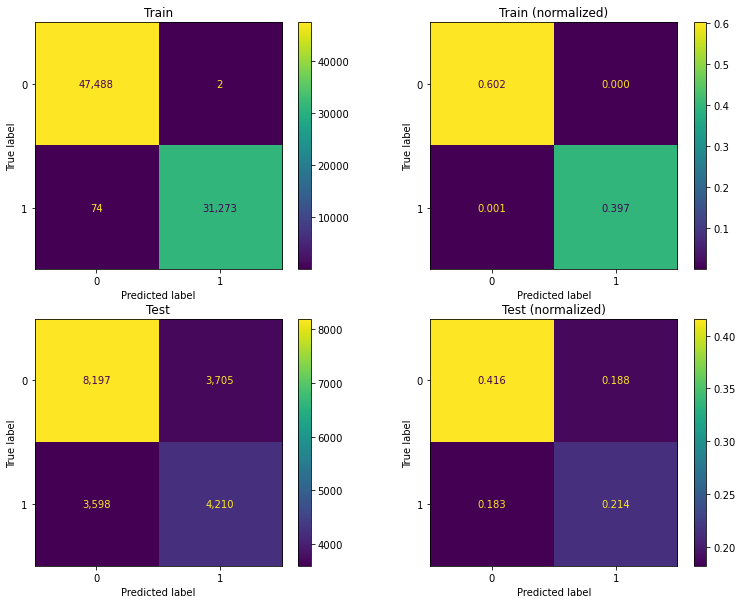

In [53]:
cm_train = confusion_matrix(Y_train, preds_train, labels = tree_model.classes_)
cm_train_norm = confusion_matrix(Y_train, preds_train, labels = tree_model.classes_, normalize = 'all')
cm_test = confusion_matrix(Y_test, preds_test, labels = tree_model.classes_)
cm_test_norm = confusion_matrix(Y_test, preds_test, labels = tree_model.classes_, normalize = 'all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13, 10))
ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = tree_model.classes_).plot(ax = ax1, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_train_norm, display_labels = tree_model.classes_).plot(ax = ax2, values_format = '.3f')
ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = tree_model.classes_).plot(ax = ax3, values_format = ',.0f')
ConfusionMatrixDisplay(confusion_matrix = cm_test_norm, display_labels = tree_model.classes_).plot(ax = ax4, values_format = '.3f')

ax1.set_title('Train')
ax2.set_title('Train (normalized)')
ax3.set_title('Test')
ax4.set_title('Test (normalized)')
plt.show()

In [54]:
pd.DataFrame([
    {
        'Train': accuracy_score(Y_train, preds_train),
        'Test': accuracy_score(Y_test, preds_test)
    },
    {
        'Train': precision_score(Y_train, preds_train),
        'Test': precision_score(Y_test, preds_test)
    },
    {
        'Train': recall_score(Y_train, preds_train),
        'Test': recall_score(Y_test, preds_test)
    },
    {
        'Train': f1_score(Y_train, preds_train),
        'Test': f1_score(Y_test, preds_test)
    }
], index = ['Accuracy', 'Precision', 'Recall', 'F1'])

Train      Test
Accuracy   0.999036  0.629477
Precision  0.999936  0.531901
Recall     0.997639  0.539191
F1         0.998786  0.535521

Este nuevo modelo de árbol de decisión presenta un problema de **overfitting** aún más marcado que los "modelos" de KNN.  
  
Por otro lado, es probable que el mejor árbol de decisión, aquel que pueda presentar un error de entrenamiento más alto pero con un error de prueba más bajo, sea uno con profundidad superior a 3 y menor a 44.

Antes de avanzar, un *insight* que se puede extraer de los modelos basados en árboles es la importancia asignada por el modelo a cada feature. Esta importancia puede ser interpretada como la contribución la feature al momento de realizar la predicción.

<AxesSubplot:ylabel='Feature'>

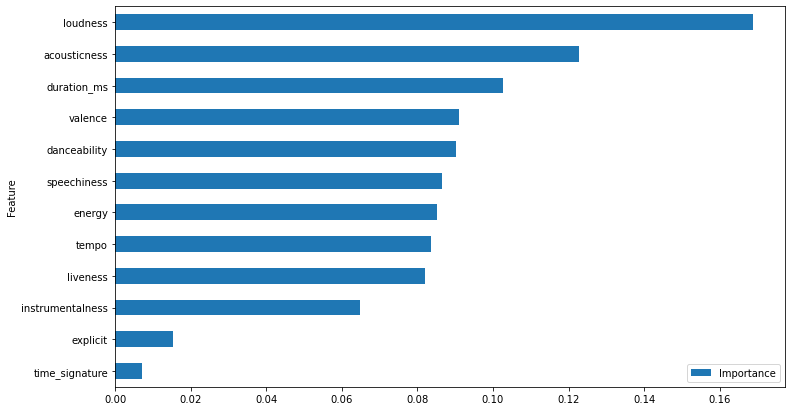

In [55]:
feature_importance_df = pd.DataFrame([features, tree_model.feature_importances_]).T
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values(by = 'Importance').plot.barh(x = 'Feature', y = 'Importance', figsize = (12, 7))

## 9. Selección del mejor modelo

Como se mencionó previamente, para encontrar el mejor modelo de árbol de decisión que se ajuste a los datos produciendo errores tanto de entrenamiento como de prueba relativamente bajos es posible variar la profundiddad del árbol. Sin embargo, hay otros hiper-parámetros que también se pueden variar que controlan el proceso de entrenamiento como son el criterior de selección de la feature a utilizar para realizar el particionamiento de los datos en un nodo dado así como la cantidad de instancias mínimas necesarias para realizar un nuevo particionamiento, entre otros. En términos de la librería sklearn los hiper-parámetros son:  

* **criterion**: "gini", "entropy". Predeterminado = "gini"
* **max_depth:**: int. Predeterminado = None
* **min_samples_split** : int. Predeterminado = 2

En lugar de entrenar de forma manual tantos modelos como combinaciones de hiper-parámetros se quieran probar, la librería sklearn proporciona la clase GridSearchCV la cuál brinda la posibilidad de entrenar todos los modelos requeridos, evaluarlos y obtener el mejor modelo. Complementariamente, esta clase también brinda la posibilidad de realizar (K-Fold) Cross-validation con el objetivo de validar la estabilidad del modelo al ser entrenado con diferentes conjuntos de entrenamiento.

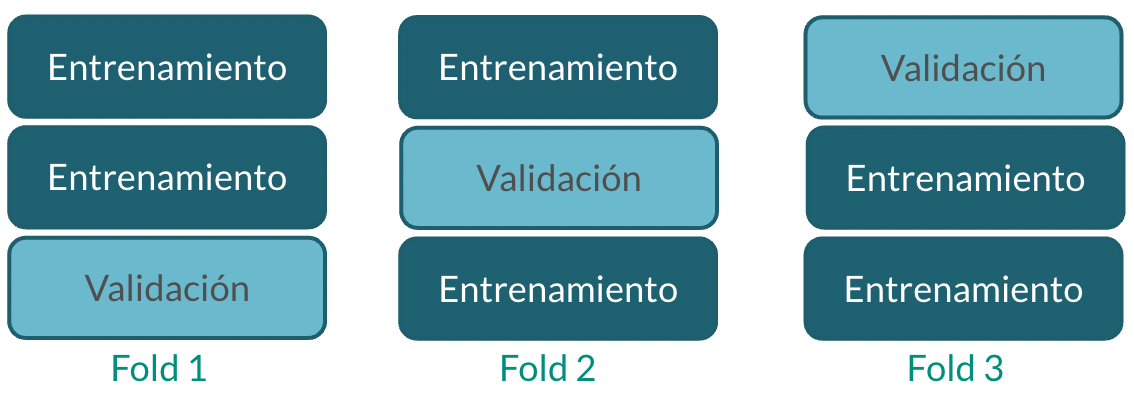

In [56]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40],
    'min_samples_split': [2, 3, 4, 5]
}

In [57]:
grid_tree_model = GridSearchCV(tree_model, param_grid, scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, n_jobs = -1, verbose = 1)

In [58]:
grid_tree_model.fit(X_train, Y_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40],
                         'min_samples_split': [2, 3, 4, 5]},
             refit='f1', scoring=['precision', 'recall', 'f1'], verbose=1)

In [59]:
# Se puede generar una tabla con todos los detalles de la ejecución
cv_results_df = pd.DataFrame(grid_tree_model.cv_results_)

In [60]:
cv_results_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.259510      0.018336         0.009146        0.002475   
1       0.226249      0.015487         0.008260        0.001769   
2       0.220121      0.011797         0.007522        0.001352   
3       0.219388      0.011305         0.007839        0.001556   
4       0.424805      0.009202         0.007393        0.001044   

  param_criterion param_max_depth param_min_samples_split  \
0            gini               4                       2   
1            gini               4                       3   
2            gini               4                       4   
3            gini               4                       5   
4            gini               8                       2   

                                              params  split0_test_precision  \
0  {'criterion': 'gini', 'max_depth': 4, 'min_sam...               0.610447   
1  {'criterion': 'gini', 'max_depth': 4, 'min_sam...               0.610447   
2  {'criterion': 'gini', 'max_depth': 4, 'min_sam...               0.610447   
3  {'criterion': 'gini', 'max_depth': 4, 'min_sam...               0.610447   
4  {'criterion': 'gini', 'max_depth': 8, 'min_sam...               0.643471   

   split1_test_precision  split2_test_precision  split3_test_precision  \
0               0.615278               0.631521               0.625551   
1               0.615278               0.631521               0.625551   
2               0.615278               0.631521               0.625551   
3               0.615278               0.631521               0.625551   
4               0.644625               0.647059               0.634036   

   split4_test_precision  split5_test_precision  split6_test_precision  \
0               0.615168               0.601589               0.610687   
1               0.615168               0.601589               0.610687   
2               0.615168               0.601589               0.610687   
3               0.615168               0.601589               0.610687   
4               0.657303               0.643175               0.642767   

   split7_test_precision  split8_test_precision  split9_test_precision  \
0               0.619417               0.613985               0.622044   
1               0.619417               0.613985               0.622044   
2               0.619417               0.613985               0.622044   
3               0.619417               0.613985               0.622044   
4               0.650309               0.654139               0.616252   

   mean_test_precision  std_test_precision  rank_test_precision  \
0             0.616569            0.008057                   17   
1             0.616569            0.008057                   17   
2             0.616569            0.008057                   17   
3             0.616569            0.008057                   17   
4             0.643314            0.010938                    5   

   split0_test_recall  split1_test_recall  split2_test_recall  \
0            0.570335            0.565231            0.552153   
1            0.570335            0.565231            0.552153   
2            0.570335            0.565231            0.552153   
3            0.570335            0.565231            0.552153   
4            0.525040            0.506858            0.494737   

   split3_test_recall  split4_test_recall  split5_test_recall  \
0            0.543541            0.556300            0.555343   
1            0.543541            0.556300            0.555343   
2            0.543541            0.556300            0.555343   
3            0.543541            0.556300            0.555343   
4            0.537161            0.522488            0.506539   

   split6_test_recall  split7_test_recall  split8_test_recall  \
0            0.561404            0.535418            0.549138   
1            0.561404            0.535418            0.549138   
2            0.561404            0.535418  

In [61]:
# También se puede obtener directamente los parámetros del mejor modelo encontrado
grid_tree_model.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}

In [62]:
# ... así como el score, en este caso F1, de dicho modelo
grid_tree_model.best_score_

0.5832007232894657

Se puede observar que la métrica F1 subió un poco. Sin embargo, una validación rigurosa implica revisar más allá de una única métrica promedio. Una alternativa es revisar la distribución obtenida para cada una de las métricas calculadas.

In [63]:
best_tree_model_results_df = cv_results_df[[ c for c in cv_results_df.columns if 'split' in c][1:]].iloc[grid_tree_model.best_index_].reset_index()
best_tree_model_results_df['split'], best_tree_model_results_df['set'], best_tree_model_results_df['metric'] = zip(*list(best_tree_model_results_df['index'].apply(lambda x: x.split('_'))))
best_tree_model_results_df.rename(columns = {grid_tree_model.best_index_: 'value'}, inplace = True)
best_tree_model_results_df.drop(columns = 'index', inplace = True)

In [64]:
best_tree_model_results_df.head()

value   split   set     metric
0  0.610447  split0  test  precision
1  0.615278  split1  test  precision
2  0.631521  split2  test  precision
3  0.625551  split3  test  precision
4  0.615168  split4  test  precision

<AxesSubplot:xlabel='metric', ylabel='value'>

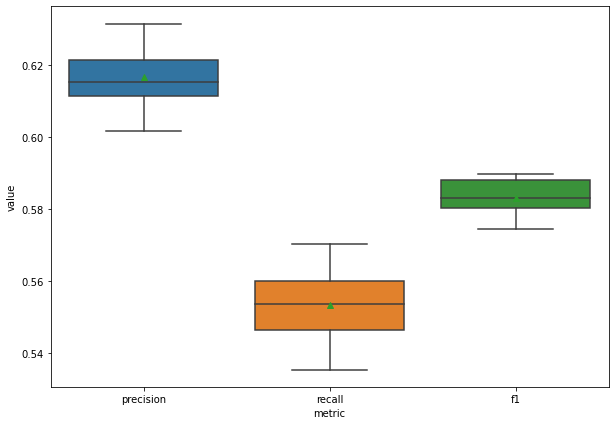

In [65]:
plt.figure(figsize = (10, 7))
sns.boxplot(x = 'metric', y = 'value', showmeans = True, data = best_tree_model_results_df)

En promedio, las 3 métricas de error se logran superar en comparación con el modelo previo, pero adicionalmente se logra ver cierta estabilidad en los resultados entre los diferentes *folds*.

## 10. Cambiando a un algoritmo de mayor complejidad

Utilzando Árboles de Decisión es posible controlar la complejidad utilizando mayoritariamente la profundidad de árbol, lo cual es limitado.  
  
Un método de ensamble combina muchos algoritmos simples para producir una predicción más robusta. Random Forest es el método de ensamble más conocido basado en árboles de decisión demostrando en muchas ocasiones un mejor performance que otros algoritmos populares como Support Vector Machines y Neural Netwoks **.  

Con Random Forest se tiene una dimensión adicional para controlar la complejidad del modelo variando el hiper-parámetro definido como número de estimadores (cantidad de árboles a entrenar haciendo selección aleatoria de features).
  
** WARNING: No free-lunch theorem.

In [66]:
forest_model = RandomForestClassifier(random_state = 2)

In [69]:
param_grid = {
    'n_estimators': [100, 200, 400],
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4]
}

In [70]:
combinations = 1
for k, v in param_grid.items():
    combinations *= len(v)

print('Total de combinaciones a validar:', combinations)

Total de combinaciones a validar: 960


Aumentar la cantidad de combinaciones de parámetros a validar tiene la desventaja del incremento exponencial en el tiempo de ejecución de todo el proceso, aún cuando se cuente con múltiples procesadores que permitan realizar procesos en paralelo. Una estrategia para mitigar esto es no hacer la búsqueda completa sino aleatoria usando la clase RandomizedSearchCV de sklearn. De esta forma se logra un *trade off* entre tiempo de ejecución y performance del mejor modelo escogido.

In [71]:
# En este caso se decide buscar solo sobre el 10% de las combinaciones
grid_forest_model = RandomizedSearchCV(forest_model, param_grid, n_iter = int(combinations / 10), scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, n_jobs = -1, verbose = 1)

In [72]:
grid_forest_model.fit(X_train, Y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2),
                   n_iter=96, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 8, 12, 16, 20, 24, 28,
                                                      32, 36, 40],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [100, 200, 400]},
                   refit='f1', scoring=['precision', 'recall', 'f1'],
                   verbose=1)

In [73]:
cv_results_df = pd.DataFrame(grid_forest_model.cv_results_)

In [74]:
cv_results_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      65.058571      0.177312         1.622844        0.087366   
1      43.572644      1.165482         0.596782        0.077421   
2      70.293804      1.859264         0.831293        0.065098   
3      75.837346      0.211838         1.329258        0.348210   
4      63.955302      0.225664         1.224599        0.180649   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                400                       5                      4   
1                200                       4                      4   
2                400                       2                      4   
3                400                       3                      1   
4                400                       5                      4   

  param_max_depth param_criterion  \
0              24            gini   
1              28         entropy   
2              16         entropy   
3              28            gini   
4              20            gini   

                                              params  split0_test_precision  \
0  {'n_estimators': 400, 'min_samples_split': 5, ...               0.669469   
1  {'n_estimators': 200, 'min_samples_split': 4, ...               0.669840   
2  {'n_estimators': 400, 'min_samples_split': 2, ...               0.666156   
3  {'n_estimators': 400, 'min_samples_split': 3, ...               0.669718   
4  {'n_estimators': 400, 'min_samples_split': 5, ...               0.670760   

   split1_test_precision  split2_test_precision  split3_test_precision  \
0               0.668210               0.675561               0.666793   
1               0.664471               0.675385               0.666410   
2               0.665253               0.672937               0.665650   
3               0.664208               0.674865               0.668598   
4               0.664225               0.676128               0.672420   

   split4_test_precision  split5_test_precision  split6_test_precision  \
0               0.670698               0.662403               0.665749   
1               0.670295               0.663328               0.662754   
2               0.668990               0.663693               0.665750   
3               0.664984               0.666409               0.656851   
4               0.671078               0.664211               0.665350   

   split7_test_precision  split8_test_precision  split9_test_precision  \
0               0.675908               0.670291               0.663787   
1               0.682917               0.668987               0.666791   
2               0.678013               0.667572               0.663284   
3               0.674873               0.670039               0.664042   
4               0.676117               0.669899               0.667670   

   mean_test_precision  std_test_precision  rank_test_precision  \
0             0.668887            0.004268                   20   
1             0.669118            0.005831                   12   
2             0.667730            0.004329                   43   
3             0.667459            0.005147                   46   
4             0.669786            0.004196                    4   

   split0_test_recall  split1_test_recall  split2_test_recall  \
0            0.558852            0.552472            0.557257   
1            0.561085            0.547049            0.560128   
2            0.554386            0.550239            0.559171   
3            0.560128            0.545774            0.560128   
4            0.557576            0.549601            0.554705   

   split3_test_recall  split4_test_recall  split5_test_recall  \
0            0.559171            0.548325            0.545136   
1            0.552472            0.549920            0.549282   
2            0.556938            0.551196            0.545774   
3            0.552153            0.546411            0.549282   
4            0.559171

In [75]:
grid_forest_model.best_params_

{'n_estimators': 400,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 40,
 'criterion': 'entropy'}

In [76]:
grid_forest_model.best_score_

0.6081753692188898

In [77]:
best_forest_model_results_df = cv_results_df[[ c for c in cv_results_df.columns if 'split' in c][1:]].iloc[grid_forest_model.best_index_].reset_index()
best_forest_model_results_df['split'], best_forest_model_results_df['set'], best_forest_model_results_df['metric'] = zip(*list(best_forest_model_results_df['index'].apply(lambda x: x.split('_'))))
best_forest_model_results_df.rename(columns = {grid_forest_model.best_index_: 'value'}, inplace = True)
best_forest_model_results_df.drop(columns = 'index', inplace = True)

In [78]:
best_forest_model_results_df.head()

value   split   set     metric
0  0.672997  split0  test  precision
1  0.665141  split1  test  precision
2  0.679507  split2  test  precision
3  0.670876  split3  test  precision
4  0.669639  split4  test  precision

<AxesSubplot:xlabel='metric', ylabel='value'>

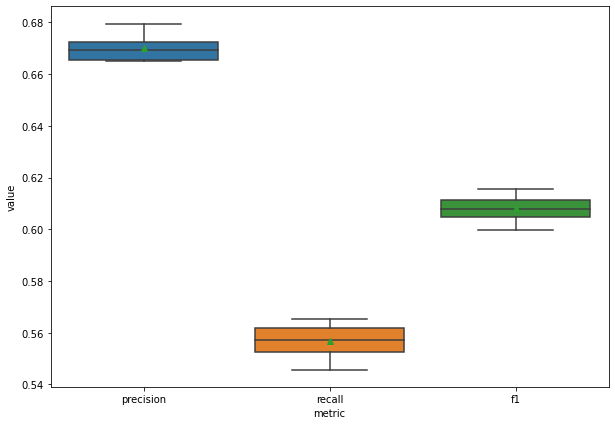

In [79]:
plt.figure(figsize = (10, 7))
sns.boxplot(x = 'metric', y = 'value', showmeans = True, data = best_forest_model_results_df)

Si bien con Random Forest no hay una mejora considerable en el error, si se puede observar una menor variabilidad de métricas para los diferentes *folds*. Se podría decir que este modelo da una mejor estabilidad en los resultados.

## 11. Evaluación del mejor modelo en conjunto de prueba

No se debe olvidar que como paso final, una vez que se ha seleccionado el mejor modelo, el objetivo es revisar como se comporta al generar predicciones en el conjunto de prueba.

In [84]:
preds_test = grid_forest_model.predict(X_test)

In [85]:
pd.DataFrame([
    {
        'Test': accuracy_score(Y_test, preds_test)
    },
    {
        'Test': precision_score(Y_test, preds_test)
    },
    {
        'Test': recall_score(Y_test, preds_test)
    },
    {
        'Test': f1_score(Y_test, preds_test)
    }
], index = ['Accuracy', 'Precision', 'Recall', 'F1'])

Test
Accuracy   0.711974
Precision  0.662746
Recall     0.555712
F1         0.604528

### 12. Serialización del modelo

Es una practica común que, una vez se ha obtenido el mejor modelo el cual está cargado en memoria de Python, este sea serializado, es decir almacenado en disco.  
  
Como resultado, será posible volver a utilizar el mismo modelo, en este caso las reglas aprendidas por el Random Forest, para generar predicciones en futuras ocasiones sin la necesidad de realizar un nuevo reentrenamiento.

In [80]:
filename = 'best_model_v1.0.pkl'

In [81]:
# Se usa la función dump de la librería pickle para serializar el modelo
pickle.dump(grid_forest_model.best_estimator_, open(filename, 'wb'))

In [82]:
# Para volverlo a cargar a memoria de Python, se usa la función load
best_model_loaded = pickle.load(open(filename, 'rb'))

In [83]:
print(best_model_loaded.predict_proba(X_test.iloc[[106]]))
print(best_model_loaded.predict(X_test.iloc[[106]]))

[[0.81648214 0.18351786]]
[0]
